<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/5%20-%20Environmental/6.439%20-%20Problem%20Set%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 5 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021

(c) Data from [MSEAS](http://mseas.mit.edu) at MIT.
***
***

# Part 0 (Execute first!)

In [1]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.zip
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z01
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z02
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z03
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z04
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z05
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z06
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS5_data.z07

# Unzip
!zip -F PS5_data.zip -O PS5_data_combined.zip
!unzip -o PS5_data_combined.zip -d PS5_data
!rm *.z* -r __MACOSX PS5_data/__MACOSX

# Clear output
clear_output()

# Import packages
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Data path
data_path = "PS5_data/"

## Functions

In [18]:
def load(filename, file_path = data_path):
  return np.genfromtxt(file_path+filename, delimiter=",")

# Problem 5.1: Flows and corelations

## (a)

The first step is to compute the average flow over time. In all matrices, the index (0,0) corresponds to the **bottom left** of each plot. Additionally, all values of each matrix are multiplied by $\frac{25}{0.9}$ for them to be in cm/second (cmps) units.

In [108]:
# Parameters
max_T = 100
max_x = 555
max_y = 504

# Initialize average values
u_average = np.zeros((max_y, max_x))
v_average = np.zeros((max_y, max_x))

for t in range(1, max_T+1):
  # Load flow data for time t
  new_u, new_v = load(f'{t}u.csv'), load(f'{t}v.csv')

  # Update averages
  u_average += (1/max_T) * new_u * 25/0.9
  v_average += (1/max_T) * new_v * 25/0.9

# Compute speeds
speed = np.sqrt(u_average**2 + v_average**2)

In [98]:
mask = load("mask.csv")

(44056,)

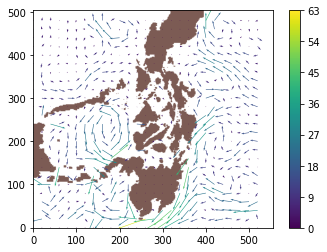

In [207]:
# Arrow positions
arrows_every = 20
x = [arrows_every * k for k in range(max_x//arrows_every)]
y = [arrows_every * k for k in range(max_y//arrows_every)]

# Initialize figure
fig, ax = plt.subplots()

# Obtain land coloration
land_cmap = plt.cm.get_cmap('gray')
land = land_cmap(mask)
land[mask == 0] = [0.49, 0.36, 0.33, 1]	

# Draw map
plt.imshow(np.flip(land,0), vmin=0, vmax=1)
plt.gca().invert_yaxis()

# Draw quiver on top of map
cmap = plt.cm
plt.quiver(x,y,u_average[y][:,x],v_average[y][:,x], speed[y][:,x])

# Show and edit colorbar
plt.colorbar(ax=ax, ticks=[9*k for k in range(8)])
plt.clim(0,63)

# Fix axis

# Show image
plt.show()

[0. 0. 0. 1.]


In [144]:
print(speed.max())

62.980196477663036


In [142]:
print(max(x))
print(u_average.shape)

520
(504, 555)


# Problem 5.2: Predicting trajectories.